# lab5-基于ESI数据的机器学习数据分析

本分析将使用数据挖掘和机器学习方法对全球高校进行多维度分析，基于包含22个学科的ESI排名数据，探索不同类型高校的学术特征，并深入分析华东师范大学的学科发展情况。

## 分析目标
1. **高校聚类分析**：基于多学科排名数据对全球高校进行聚类分析，识别不同类型的高校群体，并找出与华东师范大学相似的高校
2. **华东师范大学学科画像**：通过探索性分析从多个角度对华东师范大学进行学科画像分析
3. **学科排名预测模型**：构建机器学习模型预测各学科的排名位置（训练集60%，验证集20%，测试集20%）

## 0.导入所需库与数据准备

In [1]:
# 1. 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from kneed import KneeLocator # 用于检测肘部点
import warnings
warnings.filterwarnings('ignore')

# 导入中文字体 确保中文能正常显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid')

print("所有库已成功导入！")

所有库已成功导入！


In [2]:
# 加载数据
df = pd.read_csv('alldata.csv')

# 查看数据基本信息
print("数据集基本信息：")
print(f"数据形状: {df.shape}")
print(f"学科数量: {df['subject_name'].nunique()}")

# 缺失值处理
print(f"缺失值统计：",df.isnull().sum())
df = df.dropna()
print("\n缺失值处理后数据形状: ", df.shape)


数据集基本信息：
数据形状: (34121, 9)
学科数量: 22
缺失值统计： id                             0
subject_name                   0
institution_name               0
country_region              3161
world_rank                     0
web_of_science_documents       0
cites                          0
cites_per_paper                0
top_papers                     0
dtype: int64

缺失值处理后数据形状:  (30960, 9)


## 1.全球学科聚类分析
实现步骤：特征工程（为聚类分析做准备）-->确定最佳聚类k值-->进行kmeans聚类-->聚类结果分析并找到与华师大相似高校

In [3]:
# 特征工程
print("特征工程：构建学科矩阵 -> 类别聚合 -> 降维 -> 标准化")

# 学科列表与机构分组
all_subjects = sorted(df['subject_name'].unique())
grouped = df.groupby('institution_name')

# 定义学科类别映射（用于后续按类别聚合）
# 保持与后面深度画像分析中使用的类别一致
subject_categories = {
    'basic science': ['chemistry', 'physics', 'mathematics', 'geosciences'],
    'bioscience': ['biology & biochemistry', 'plant & animal science', 'molecular biology & genetics',
                 'microbiology', 'neuroscience & behavior', 'immunology'],
    'midecal': ['clinical medicine', 'pharmacology & toxicology', 'psychiatry psychology'],
    'engineering&tech': ['engineering', 'materials science', 'computer science'],
    'ecology': ['agricultural sciences', 'environment ecology'],
    'social science': ['social sciences, general', 'economics & business'],
    'others': ['multidisciplinary', 'space science']
}

# 存放行数据
university_names = []
presence_rows = []
perf_rows = []
impact_rows = []
scale_rows = []
subject_counts = []
avg_ranks = []

for uni, uni_df in grouped:
    if len(uni_df) < 3:  # 可调整阈值
        continue
    university_names.append(uni)
    subject_counts.append(len(uni_df))
    avg_ranks.append(uni_df['world_rank'].mean())

    # 用 subject_name 对齐到 all_subjects，方便向量化
    s = uni_df.set_index('subject_name')
    s = s.reindex(all_subjects)

    pres = s['world_rank'].notna().astype(int).fillna(0).values
    #perf = s['world_rank'].apply(lambda r: max(0, (2000 - r) / 2000) if pd.notna(r) else 0.0).fillna(0).values
    perf = s['world_rank'].apply(lambda r: 1 / (1 + np.exp((r - 100) / 50)) if pd.notna(r) else 0.0).fillna(0).values
    imp = s['cites_per_paper'].apply(lambda x: min(1.0, x / 50) if pd.notna(x) else 0.0).fillna(0).values
    sca = s['web_of_science_documents'].apply(lambda x: min(1.0, x / 5000) if pd.notna(x) else 0.0).fillna(0).values

    presence_rows.append(pres)
    perf_rows.append(perf)
    impact_rows.append(imp)
    scale_rows.append(sca)

# 转为 DataFrame（索引为机构名）
presence_df = pd.DataFrame(presence_rows, columns=[f'has_{s}' for s in all_subjects], index=university_names)
perf_df = pd.DataFrame(perf_rows, columns=[f'perf_{s}' for s in all_subjects], index=university_names)
impact_df = pd.DataFrame(impact_rows, columns=[f'impact_{s}' for s in all_subjects], index=university_names)
scale_df = pd.DataFrame(scale_rows, columns=[f'scale_{s}' for s in all_subjects], index=university_names)

# 检查矩阵一致性
assert presence_df.shape[0] == perf_df.shape[0], '行数不一致'
assert presence_df.shape[1] == len(all_subjects), '列数与学科数量不匹配'

# 类别强度：基于 perf 与 impact 的均值聚合（更稳健且可解释）
category_strengths = pd.DataFrame(index=university_names)
for cat, subs in subject_categories.items():
    perf_cols = [f'perf_{s}' for s in subs if f'perf_{s}' in perf_df.columns]
    imp_cols = [f'impact_{s}' for s in subs if f'impact_{s}' in impact_df.columns]

    # 计算类别内的 perf_mean 与 impact_mean；若某一项缺失则用0填充
    mean_perf = perf_df[perf_cols].mean(axis=1) if perf_cols else pd.Series(0.0, index=university_names)
    mean_imp = impact_df[imp_cols].mean(axis=1) if imp_cols else pd.Series(0.0, index=university_names)

    # 将两者平均作为类别实力得分（可后续调整权重）
    category_strengths[f'category_{cat}'] = (mean_perf + mean_imp) / 2.0

# 对 presence / perf 做降维以降低维度（保留信息）
max_components = min(8, max(1, len(all_subjects) - 1))

svd_pres = TruncatedSVD(n_components=max_components, random_state=42)
pres_comp = svd_pres.fit_transform(presence_df)
pres_cols = [f'pres_comp_{i+1}' for i in range(pres_comp.shape[1])]
pres_df = pd.DataFrame(pres_comp, index=university_names, columns=pres_cols)

svd_perf = TruncatedSVD(n_components=min(max_components, perf_df.shape[1]), random_state=42)
perf_comp = svd_perf.fit_transform(perf_df)
perf_cols = [f'perf_comp_{i+1}' for i in range(perf_comp.shape[1])]
perf_comp_df = pd.DataFrame(perf_comp, index=university_names, columns=perf_cols)

# 合并用于聚类的特征
university_features_matrix = pd.concat([
    pres_df, perf_comp_df, category_strengths,
    pd.DataFrame({'subject_count': subject_counts, 'avg_rank': avg_ranks}, index=university_names)
], axis=1)

print(f"降维后特征矩阵形状: {university_features_matrix.shape}")

# 标准化
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(university_features_matrix)
X_cluster_scaled_df = pd.DataFrame(X_scaled, index=university_names, columns=university_features_matrix.columns)

# 基本信息字典（供后续分析使用）
university_basic_info = {u: {'subject_count': subject_counts[i], 'avg_rank': avg_ranks[i],
                             'best_rank': df[df['institution_name']==u]['world_rank'].min(),
                             'country_region': df[df['institution_name']==u]['country_region'].iloc[0],
                             'subjects': df[df['institution_name']==u]['subject_name'].tolist()}
                         for i,u in enumerate(university_names)}

print('\n特征工程完成，已生成 X_cluster_scaled_df 与 university_basic_info。')

特征工程：构建学科矩阵 -> 类别聚合 -> 降维 -> 标准化
降维后特征矩阵形状: (3198, 25)

特征工程完成，已生成 X_cluster_scaled_df 与 university_basic_info。


基于肘部法则推荐的聚类数量: k = 5 (WCSS: 50945)


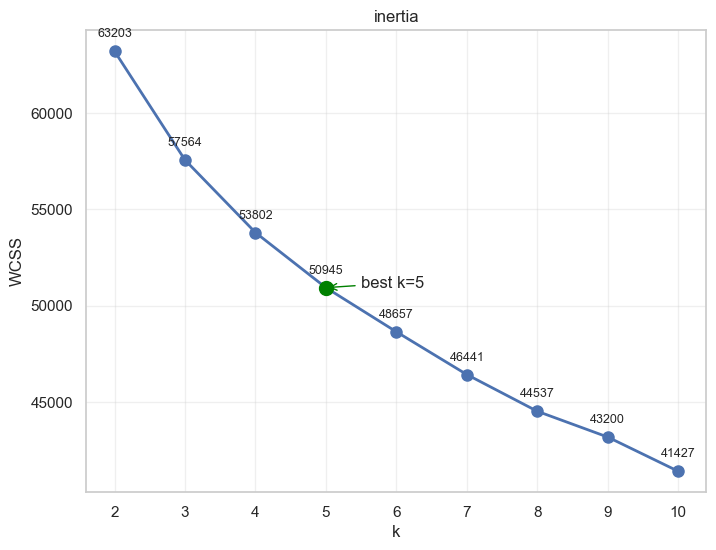

In [4]:
# -----确定最优聚类数量-----
def evaluate_clustering(X, k_range):
    """评估不同聚类数量的效果"""
    inertias = []
    
    for k in k_range:
        # K-means聚类
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        # 利用WCSS计算评估指标
        inertias.append(kmeans.inertia_)
    return inertias

# 测试聚类数量范围（2-10）
k_range = range(2, 11)
# 使用 X_cluster_scaled_df 作为聚类评估输入
inertias = evaluate_clustering(X_cluster_scaled_df, k_range)

#------绘制评估结果-----
fig, axes = plt.subplots(figsize=(8, 6))

# 肘部法则（画图）
axes.plot(k_range, inertias, 'bo-', markersize=8, linewidth=2)
axes.set_xlabel('k')
axes.set_ylabel('WCSS') # 簇内平方和
axes.set_title('inertia')
axes.grid(True, alpha=0.3)

# 添加注释
for i, (k, inertia) in enumerate(zip(k_range, inertias)):
    axes.annotate(f'{inertia:.0f}', (k, inertia), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

kl = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
best_k_elbow = kl.elbow
optimal_k = best_k_elbow
# 仅当 KneeLocator 返回的肘部在 k_range 内且可索引时才取值
if best_k_elbow is not None and best_k_elbow in list(k_range):
    try:
        best_elbow = inertias[list(k_range).index(best_k_elbow)]
    except Exception:
        best_elbow = None

# 检测到有效肘部时在图上标注（放在 inertia 图上），避免对 None 执行加法
if best_k_elbow is not None and best_elbow is not None:
    axes.scatter([best_k_elbow], [best_elbow], color='green', s=100, zorder=5)
    axes.annotate(f'best k={best_k_elbow}', 
                    xy=(best_k_elbow, best_elbow),
                    xytext=(best_k_elbow+0.5, best_elbow+0.01),
                    arrowprops=dict(arrowstyle='->', color='green'))
else:
    # 在子图角落标注未检测到肘部
    axes.text(0.98, 0.95, '未检测到明显肘部', ha='right', va='top', transform=axes[0].transAxes, fontsize=9, color='gray')

# 打印友好提示（根据是否存在有效肘部给出不同输出）
if best_k_elbow is None or best_elbow is None:
    print(f"基于肘部法则推荐的聚类数量: 未检测到明显肘部")
else:
    print(f"基于肘部法则推荐的聚类数量: k = {best_k_elbow} (WCSS: {best_elbow:.0f})")

In [5]:
# 执行最终聚类分析（已修复：使用 X_cluster_scaled_df 作为主数据）
print("="*80)
print("执行最终聚类分析")
print("="*80)

# 使用 X_cluster_scaled_df作为聚类输入
X_df = X_cluster_scaled_df.copy()

# 使用之前确定的聚类数量
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_df.values)

print(f"最终聚类结果 (k={optimal_k}):")

# 将聚类标签写回 DataFrame
X_cluster_scaled_df['cluster'] = labels

# 分析聚类分布
cluster_counts = X_cluster_scaled_df['cluster'].value_counts().sort_index()
print("各聚类大小分布:")
for cluster_id, count in cluster_counts.items():
    percentage = count / len(X_cluster_scaled_df) * 100
    print(f"聚类 {cluster_id}: {count} 所高校 ({percentage:.1f}%)")
print()

# 分析华师大所在聚类
target = 'EAST CHINA NORMAL UNIVERSITY'
ecnu_cluster = int(X_cluster_scaled_df.loc[target, 'cluster'])
ecnu_cluster_size = int(cluster_counts.get(ecnu_cluster, 0))
print(f"华东师范大学所在聚类: 聚类 {ecnu_cluster}")
print(f"该聚类包含 {ecnu_cluster_size} 所高校 ({ecnu_cluster_size/len(X_cluster_scaled_df)*100:.1f}%)")

执行最终聚类分析
最终聚类结果 (k=5):
各聚类大小分布:
聚类 0: 894 所高校 (28.0%)
聚类 1: 454 所高校 (14.2%)
聚类 2: 146 所高校 (4.6%)
聚类 3: 518 所高校 (16.2%)
聚类 4: 1186 所高校 (37.1%)

华东师范大学所在聚类: 聚类 1
该聚类包含 454 所高校 (14.2%)


In [6]:
# 聚类结果分析
print("="*80)
print("聚类结果分析")
print("="*80)

print("聚类分布概览:")
for cluster_id in sorted(X_cluster_scaled_df['cluster'].unique()):
    cluster_unis = X_cluster_scaled_df[X_cluster_scaled_df['cluster'] == cluster_id].index.tolist()
    count = len(cluster_unis)
    percentage = count / len(X_cluster_scaled_df) * 100
    print(f"\n聚类 {cluster_id}: 高校数量: {count} 所 ({percentage:.1f}%)")

    # 显示代表性高校（根据 best_rank 排序）
    rep_sorted = sorted(
        cluster_unis,
        key=lambda u: university_basic_info.get(u, {}).get('best_rank', float('inf'))
    )
    print(f"  代表性高校（前5所）:")
    for i, uni in enumerate(rep_sorted[:5]):
        countryRegion = university_basic_info[uni]['country_region']
        print(f"    {i+1}. {uni} (国家: {countryRegion})")


# =============================
# 分析华东师范大学及最相似高校
# =============================
target = 'EAST CHINA NORMAL UNIVERSITY' # 这里有需要也可以改为其他学校的名字

# 获取 ECNU 的聚类信息
ecnu_cluster = int(X_cluster_scaled_df.loc[target, 'cluster'])
ecnu_cluster_size = int((X_cluster_scaled_df['cluster'] == ecnu_cluster).sum())
print(f"{target}所属聚类: 聚类 {ecnu_cluster} ，该聚类包含 {ecnu_cluster_size} 所高校")

# 提取该聚类中所有高校的特征向量（不含 cluster 标签）
same_cluster_mask = (X_cluster_scaled_df['cluster'] == ecnu_cluster)
cluster_features = X_cluster_scaled_df[same_cluster_mask].drop(columns=['cluster'])  # 去掉标签列

# 提取 ECNU 的特征向量
ecnu_vector = X_cluster_scaled_df.loc[target].drop('cluster')  # Series without cluster

# 计算每所高校与 ECNU 的欧氏距离
from scipy.spatial.distance import cdist
distances = cdist(
    cluster_features.values,
    ecnu_vector.values.reshape(1, -1),
    metric='euclidean'
).flatten()

# 构建 (大学名, 距离) 列表，并按距离升序排列
similar_pairs = [(name, dist) for name, dist in zip(cluster_features.index, distances)]
similar_pairs.sort(key=lambda x: x[1])  # 按距离从小到大排序

# 排除 ECNU 自身，取 Top-K 最相似高校
top_k = 30
similar_unis = [item for item in similar_pairs if item[0] != target][:top_k]

print(f"\n与{target}最相似的 {len(similar_unis)} 所高校（基于特征向量距离排序）:")
for i, (uni, dist) in enumerate(similar_unis):
    info = university_basic_info.get(uni, {})
    avg_r = info.get('avg_rank', 'N/A')
    best_r = info.get('best_rank', 'N/A')
    country = info.get('country_region', '未知')
    print(f"  {i+1:2d}. {uni}| 地区: {country} | 相似距离: {dist:.3f} | 平均排名: {avg_r:.1f} | 最好排名: {best_r} ")

聚类结果分析
聚类分布概览:

聚类 0: 高校数量: 894 所 (28.0%)
  代表性高校（前5所）:
    1. NATIONAL BUREAU OF ECONOMIC RESEARCH (国家: USA)
    2. CNRS - NATIONAL INSTITUTE FOR MATHEMATICAL SCIENCES (INSMI) (国家: FRANCE)
    3. ISTITUTO NAZIONALE DI FISICA NUCLEARE (INFN) (国家: ITALY)
    4. LONDON SCHOOL ECONOMICS & POLITICAL SCIENCE (国家: ENGLAND)
    5. ERASMUS UNIVERSITY ROTTERDAM - EXCL ERASMUS MC (国家: NETHERLANDS)

聚类 1: 高校数量: 454 所 (14.2%)
  代表性高校（前5所）:
    1. EGYPTIAN KNOWLEDGE BANK (EKB) (国家: EGYPT)
    2. CHINESE ACADEMY OF AGRICULTURAL SCIENCES (国家: CHINA MAINLAND)
    3. INDIAN INSTITUTE OF TECHNOLOGY SYSTEM (IIT SYSTEM) (国家: INDIA)
    4. UNITED STATES DEPARTMENT OF AGRICULTURE (USDA) (国家: USA)
    5. CHINA AGRICULTURAL UNIVERSITY (国家: CHINA MAINLAND)

聚类 2: 高校数量: 146 所 (4.6%)
  代表性高校（前5所）:
    1. CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE (CNRS) (国家: FRANCE)
    2. CHINESE ACADEMY OF SCIENCES (国家: CHINA MAINLAND)
    3. HARVARD UNIVERSITY (国家: USA)
    4. UNIVERSITY OF CALIFORNIA SYSTEM (国家: USA)
    5

## 2.ECNU学科画像


学科结构分析和可视化...


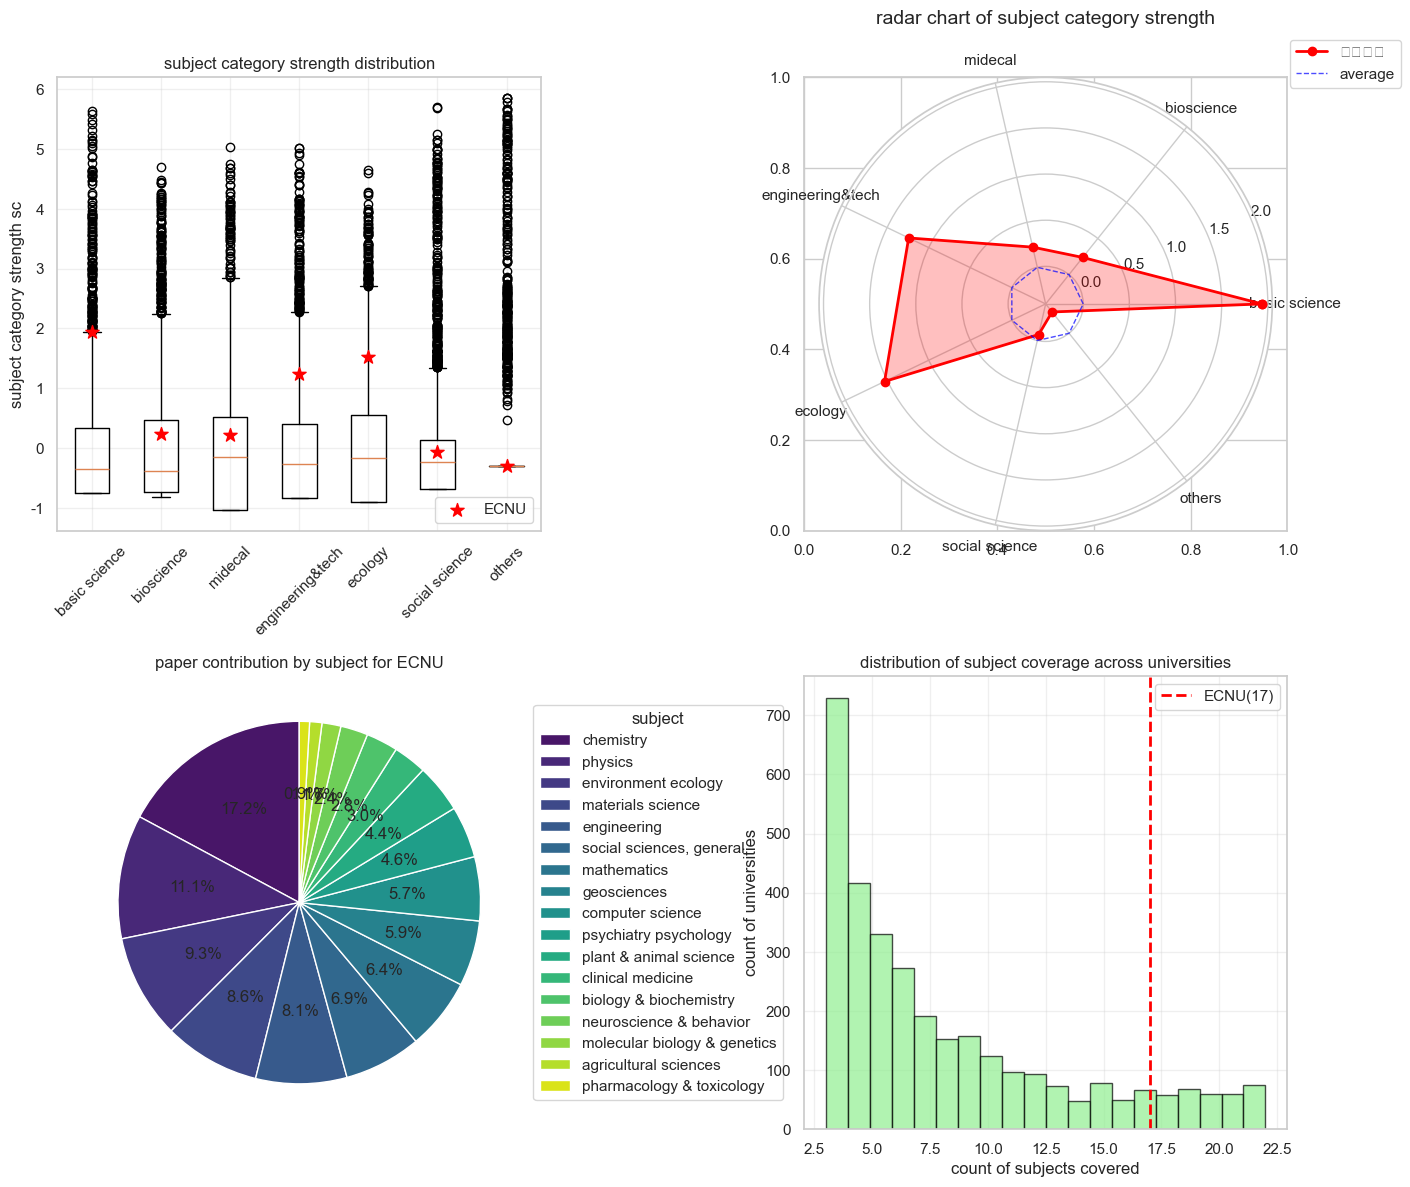

In [7]:
# ECNU学科画像分析与可视化
print("\n学科结构分析和可视化...")
# -------------------------------
# 1. 准备数据
# -------------------------------

# 学科类别数据
category_cols = [c for c in X_cluster_scaled_df.columns if c.startswith('category_')]
if category_cols:
    category_data = X_cluster_scaled_df[category_cols].copy()
    category_names = [c.replace('category_', '') for c in category_cols]
else:
    category_data = pd.DataFrame(index=X_cluster_scaled_df.index)
    category_names = []

# 学科覆盖广度
subject_coverage = pd.Series({
    uni: university_basic_info.get(uni, {}).get('subject_count', 0)
    for uni in X_cluster_scaled_df.index
})

# 获取华东师范大学原始数据
target_uni = 'EAST CHINA NORMAL UNIVERSITY'
ecnu_data_raw = df[df['institution_name'] == target_uni].copy()

# 安全检查并计算指标
if len(ecnu_data_raw) > 0 and 'web_of_science_documents' in ecnu_data_raw.columns:
    total_docs = ecnu_data_raw['web_of_science_documents'].sum()
    total_cites = ecnu_data_raw['cites'].sum()

    if total_docs > 0:
        ecnu_data_raw['doc_contribution'] = ecnu_data_raw['web_of_science_documents'] / total_docs * 100
    else:
        ecnu_data_raw['doc_contribution'] = 0

    if total_cites > 0:
        ecnu_data_raw['cite_contribution'] = ecnu_data_raw['cites'] / total_cites * 100
    else:
        ecnu_data_raw['cite_contribution'] = 0

    # 顶级论文比例（Top Papers / 总论文）
    valid_mask = ecnu_data_raw['web_of_science_documents'] > 0
    ecnu_data_raw['top_paper_ratio'] = 0
    ecnu_data_raw.loc[valid_mask, 'top_paper_ratio'] = (
        ecnu_data_raw.loc[valid_mask, 'top_papers'] / ecnu_data_raw.loc[valid_mask, 'web_of_science_documents'] * 100
    )

    ecnu_plot_data = ecnu_data_raw.sort_values('web_of_science_documents', ascending=False)
else:
    ecnu_plot_data = pd.DataFrame()

# -------------------------------
# 2. 创建统一的 2x2 子图布局
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# -------------------------------
# 图1: 学科类别实力分布箱线图 + 标注华师大
# -------------------------------
if not category_data.empty and len(category_names) > 0:
    cat_df = category_data.copy()
    cat_df.columns = category_names

    box_data = [cat_df[col] for col in category_names]
    axes[0, 0].boxplot(box_data, labels=category_names)
    axes[0, 0].set_title('subject category strength distribution')
    axes[0, 0].set_ylabel('subject category strength sc')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)

    # 标注华师大
    if target_uni in cat_df.index:
        ecnu_vals = cat_df.loc[target_uni]
        for i, score in enumerate(ecnu_vals):
            axes[0, 0].scatter(i+1, score, color='red', s=100, marker='*', zorder=10, label='ECNU' if i==0 else "")
        axes[0, 0].legend()
else:
    axes[0, 0].text(0.5, 0.5, '无学科类别数据', ha='center', va='center', transform=axes[0, 0].transAxes)

# -------------------------------
# 图2: 华师大学科结构雷达图（极坐标）
# -------------------------------
ax_radar = fig.add_subplot(2, 2, 2, polar=True)  # 覆盖右下角，使用极坐标

if category_names and target_uni in category_data.index:
    ecnu_vals = category_data.loc[target_uni].values.tolist()
    angles = np.linspace(0, 2 * np.pi, len(category_names), endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    ecnu_vals += ecnu_vals[:1]

    # 绘制华师大
    ax_radar.plot(angles, ecnu_vals, 'o-', linewidth=2, label='华东师大', color='red')
    ax_radar.fill(angles, ecnu_vals, alpha=0.25, color='red')

    # 绘制全国平均
    avg_vals = category_data.mean().values.tolist()
    avg_vals += avg_vals[:1]
    ax_radar.plot(angles, avg_vals, '--', linewidth=1, label='average', color='blue', alpha=0.7)

    # 设置标签和标题
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(category_names)
    ax_radar.set_title('radar chart of subject category strength', y=1.1, fontsize=14)
    ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax_radar.grid(True)
else:
    ax_radar.text(0.5, 0.5, '数据缺失', transform=ax_radar.transAxes, ha='center', va='center', fontsize=12)


# -------------------------------
# 图3: 华师大各学科论文贡献饼图
# -------------------------------
if len(ecnu_plot_data) > 0 and 'doc_contribution' in ecnu_plot_data.columns:
    subjects = ecnu_plot_data['subject_name']
    doc_contrib = ecnu_plot_data['doc_contribution']

    colors = sns.color_palette("viridis", len(subjects))
    wedges, texts, autotexts = axes[1, 0].pie(
        doc_contrib, labels=None, autopct='%1.1f%%',
        startangle=90, colors=colors
    )
    axes[1, 0].set_title('paper contribution by subject for ECNU')

    # 添加图例（放在右侧）
    axes[1, 0].legend(wedges, subjects, title="subject", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
else:
    axes[1, 0].text(0.5, 0.5, '无论文数据', ha='center', va='center', transform=axes[1, 0].transAxes)

# -------------------------------
# 图4: 高校学科覆盖广度分布直方图 + 华师大竖线
# -------------------------------
axes[1, 1].hist(subject_coverage, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('distribution of subject coverage across universities')
axes[1, 1].set_xlabel('count of subjects covered')
axes[1, 1].set_ylabel('count of universities')
axes[1, 1].grid(True, alpha=0.3)

# 标注华师大
if target_uni in subject_coverage.index:
    ecnu_coverage = subject_coverage.loc[target_uni]
    axes[1, 1].axvline(ecnu_coverage, color='red', linestyle='--', linewidth=2, label=f'ECNU({ecnu_coverage})')
    axes[1, 1].legend()


# -------------------------------
# 3. 最终布局调整
# -------------------------------
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 为右侧图例留空间
plt.show()

## 3.学科排名预测

In [8]:
# 选择预测特征
prediction_features = ['web_of_science_documents', 'cites', 'cites_per_paper', 'top_papers']

# 存储每个学科的结果
all_results = []

# 获取所有学科
subjects = df['subject_name'].unique()

for subject in subjects:
    sub_df = df[df['subject_name'] == subject].copy()
    
    # 特征和目标
    X = sub_df[prediction_features]
    y = sub_df['world_rank']
    
    # 数据分割 (60% 训练 / 20% 验证 / 20% 测试)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42
    )
    
    # 定义两个模型
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    }
    
    model_perf = {}  # 用于存储两个模型的性能

    for name, model in models.items():
        try:
            # 训练
            model.fit(X_train, y_train)
            
            # 预测测试集
            test_pred = model.predict(X_test)
            
            # 计算评估指标
            r2 = r2_score(y_test, test_pred)
            mae = mean_absolute_error(y_test, test_pred)
            mse = mean_squared_error(y_test, test_pred)
            
            # 提取特征重要性（用于排序）
            if name == 'Random Forest':
                importance = model.feature_importances_
            elif name == 'Linear Regression':
                importance = np.abs(model.coef_)
            else:
                importance = [0] * len(prediction_features)
                
            # 保存性能
            model_perf[name] = {
                'r2': r2,
                'mae': mae,
                'mse': mse,
                'importance': np.array(importance),
                'pred': test_pred,
                'true': y_test.values
            }
            
        except Exception as e:
            print(f"{subject} - {name} 训练失败: {e}")
            continue
    
    # ================================
    # 输出当前学科两个模型的性能
    # ================================
    lr_r2 = model_perf['Linear Regression']['r2']
    lr_mae = model_perf['Linear Regression']['mae']
    lr_mse = model_perf['Linear Regression']['mse']
    
    rf_r2 = model_perf['Random Forest']['r2']
    rf_mae = model_perf['Random Forest']['mae']
    rf_mse = model_perf['Random Forest']['mse']
    
    print(f"\n{subject}")
    print(f"   {'模型':<18} {'R²':>8} {'MAE':>8} {'MSE':>8}")
    print(f"   {'-'*40}")
    print(f"   {'线性回归':<18} {lr_r2:>8.4f} {lr_mae:>8.2f} {lr_mse:>8.2f}")
    print(f"   {'随机森林':<18} {rf_r2:>8.4f} {rf_mae:>8.2f} {rf_mse:>8.2f}")
    
    # 推荐更优模型（基于 R²）
    best_model_name = 'Linear Regression' if lr_r2 > rf_r2 else 'Random Forest'
    print(f" 推荐模型: {best_model_name}")

    # 获取最佳模型的特征重要性排序
    best_imp = model_perf[best_model_name]['importance']
    sorted_imp = sorted(zip(prediction_features, best_imp), key=lambda x: x[1], reverse=True)

    
    # 保存所有信息（包括双模型指标）
    all_results.append({
        'subject': subject,
        'sample_size': len(sub_df),
        
        # 线性回归性能
        'lr_r2': lr_r2,
        'lr_mae': lr_mae,
        'lr_mse': lr_mse,
        
        # 随机森林性能
        'rf_r2': rf_r2,
        'rf_mae': rf_mae,
        'rf_mse': rf_mse,
        
        # 最佳模型
        'best_model': best_model_name,
        'test_r2': model_perf[best_model_name]['r2'],
        'test_mae': model_perf[best_model_name]['mae'],
        'test_mse': model_perf[best_model_name]['mse'],
        
        # 关键特征
        'top_feature': sorted_imp[0][0],
        'importance_detail': sorted_imp
    })



# ================================
# 总体统计
# ================================
results_df = pd.DataFrame(all_results)
print("\n性能对比统计:")
print(f"线性回归平均 R²: {results_df['lr_r2'].mean():.3f}")
print(f"随机森林平均 R²: {results_df['rf_r2'].mean():.3f}")
print(f"随机森林平均 MSE: {results_df['rf_mse'].mean():.2f}")
print(f"线性回归平均 MSE: {results_df['lr_mse'].mean():.2f}")
print(f"随机森林选取的最关键特征为{results_df['top_feature'].value_counts().idxmax()}")


agricultural sciences
   模型                       R²      MAE      MSE
   ----------------------------------------
   线性回归                 0.3857   273.42 95933.85
   随机森林                 1.0000     1.28     2.42
 推荐模型: Random Forest

biology & biochemistry
   模型                       R²      MAE      MSE
   ----------------------------------------
   线性回归                 0.4718   301.50 117877.64
   随机森林                 1.0000     1.40     3.08
 推荐模型: Random Forest

chemistry
   模型                       R²      MAE      MSE
   ----------------------------------------
   线性回归                 0.2818   451.98 278230.30
   随机森林                 1.0000     1.46     3.30
 推荐模型: Random Forest

clinical medicine
   模型                       R²      MAE      MSE
   ----------------------------------------
   线性回归                 0.2331  1397.71 2744267.52
   随机森林                 1.0000     1.89     6.17
 推荐模型: Random Forest

computer science
   模型                       R²      MAE      MSE
   -